#파이썬 라이브러리 버전 : 3.10버전 사용

In [ ]:
import pandas as pd

#수집한 진짜 뉴스 데이터와 가짜 뉴스 읽어오기
true_df = pd.read_csv('True.csv') #21417개
fake_df = pd.read_csv('Fake.csv') #23481개 42834

In [ ]:
#결측값 제거함수
fake_df = fake_df.dropna(subset=['title', 'text'], how='all')
true_df = true_df.dropna(subset=['title', 'text'], how='all')

#진짜 뉴스 데이터는 1, 가짜 뉴스 데이터는 0으로 데이터 라벨링
true_df['label'] = 1
fake_df['label'] = 0

#데이터의 수가 적은 true_df에 맞게 데이터 개수 조절하여 데이터 불균형 해소
filtered_fake_df = fake_df.sample(n = 21417, random_state=42)

#데이터 결합 
totalnews_df = pd.concat([true_df, filtered_fake_df]).reset_index(drop=True)


In [3]:
#결측값 확인 함수 --> 현재 데이터셋은 결측값 X
print(totalnews_df.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [ ]:
import re
from bs4 import BeautifulSoup
from tqdm import tqdm

#전처리 함수 - BERT임베딩 고려하여 최소한의 전처리 진행
def process_text(text):
    # 1. HTML 태그 제거
    text = BeautifulSoup(text, "html.parser").get_text()   
    # 4. 공백 정리
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

#title과 text 따로 전처리
tqdm.pandas(desc="텍스트 전처리 진행 중")
totalnews_df['cleaned_title'] = totalnews_df['title'].progress_apply(process_text)
totalnews_df['cleaned_text'] = totalnews_df['text'].progress_apply(process_text)

텍스트 전처리 진행 중:  47%|████▋     | 20119/42834 [00:00<00:00, 34520.13it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_140204\2306856224.py:9: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(t

In [ ]:
granular_subjects = {
    #새로운 주제 체계 생성
    'presidential_news' : ['trump', 'biden', 'obama', 'white house', 'oval office', 'president', 'potus'],
    'political_news' : ['prime minister', 'senate', 'congress', 'republican', 'democrat', 'government', 'agency'],
    'international_news' : ['russia', 'china', 'north korea', 'kim jong un', 'putin', 'foreign', 'iran', 'international', 'global', 'south korea'],
    'crime_news' : ['arrested', 'charged', 'murder', 'shooting', 'police', 'court', 'judge', 'investigation', 'criminal'],
    'media_news' : ['cnn', 'fox news', 'msnbc', 'reporter', 'interview', 'broadcast', 'journalist'],
    'conspiracy_theory' : ['deep state', 'soros', 'qanon', 'hoax', 'false flag', 'fake news', 'conspiracy'],
    'economy_news' : ['economy', 'stock', 'market', 'jobs', 'employment', 'gdp', 'inflation'],
    'health_news': ['vaccine', 'health', 'hospital', 'doctor', 'cdc']
}

In [ ]:
from collections import defaultdict

#새로운 주제 체계 적용하는 함수
def refined_granular_subjects(title, text, return_multiple=False):
    combined = f"{str(title)} {str(text)}".lower()
    subject_counter = defaultdict(int)  # 주제별 키워드 카운트 딕셔너리
    
    #모든 주제와 키워드 순회
    for subject, keywords in granular_subjects.items():
        for kw in keywords:
            # 정규표현식으로 단어 단위 매칭 (대소문자 구분 없음)
            if re.search(r'\b' + re.escape(kw) + r'\b', combined):
                subject_counter[subject] += 1
    
    #가장 많이 포함된 주제 찾기기
    if not subject_counter:
        return 'general' if not return_multiple else []
    
    max_count = max(subject_counter.values())
    max_subjects = [subj for subj, cnt in subject_counter.items() if cnt == max_count]
    
    #만일 여러 주제의 카운트가 동일한 경우 첫번째 주제 할당
    return max_subjects[0]

In [ ]:
#주제 할당 함수 적용
totalnews_df['subject'] = totalnews_df.apply(lambda row: refined_granular_subjects(row['cleaned_title'], row['cleaned_text']), axis=1)

In [ ]:
#각 주제별 갯수 확인
subject_counts = totalnews_df['subject'].value_counts()
print(subject_counts)

subject
presidential_news     21583
political_news         8778
crime_news             4219
international_news     4051
general                2113
media_news             1250
economy_news            507
health_news             253
conspiracy_theory        80
Name: count, dtype: int64


In [ ]:
#감성분석
import nltk
from nltk.corpus import opinion_lexicon 
from nltk.tokenize import word_tokenize

#긍정, 부정 단어 리스트 다운로드
nltk.download('opinion_lexicon')
nltk.download('punkt')

#긍정 및 부정 단어 리스트 로드
positive_words = set(opinion_lexicon.positive()) #긍정 단어 집합
negative_words = set(opinion_lexicon.negative()) #부정 단어 집합

#텍스트에서 긍정 단어 수와 부정 단어 수를 모두 계산하여 반환
def count_sentiment_words(text):
    
    # 토큰화 : 정확한 구분 위함, 소문자화 : 사전에는 대문자 등록 X
    tokens = word_tokenize(text.lower())
    
    #긍정 단어 수 계산
    positive_words_count = sum(1 for word in tokens if word in positive_words)
    
    #부정 단어 수 계산
    negative_words_count = sum(1 for word in tokens if word in negative_words)
    
    return positive_words_count, negative_words_count


[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\JinsuRoh\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JinsuRoh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#진짜 뉴스 텍스트 결합
true_news = ' '.join((totalnews_df.loc[totalnews_df['label'] == 1]['cleaned_title'].astype(str) 
                          + ' ' + totalnews_df.loc[totalnews_df['label'] == 1]['cleaned_text'].astype(str)))

#가짜 뉴스 텍스트 결합
fake_news = ' '.join((totalnews_df.loc[totalnews_df['label'] == 0]['cleaned_title'].astype(str) 
                          + ' ' + totalnews_df.loc[totalnews_df['label'] == 0]['cleaned_text'].astype(str)))


In [ ]:
#진짜 뉴스 긍정/부정 단어 수 계산
true_news_positive_words_count, true_news_negative_words_count = count_sentiment_words(true_news)

#가짜 뉴스 긍정/부정 단어 수 계산
fake_news_positive_words_count, fake_news_negative_words_count = count_sentiment_words(fake_news)

#결과 출력
print(f"진짜 뉴스의 긍정 단어 수: {true_news_positive_words_count}, 부정 단어 수: {true_news_negative_words_count}")
print(f"가짜 뉴스의 긍정 단어 수: {fake_news_positive_words_count}, 부정 단어 수: {fake_news_negative_words_count}")

#뉴스 1건당 평균 단어 수 계산 
true_count = (totalnews_df['label'] == 1).sum()
fake_count = (totalnews_df['label'] == 0).sum()
print("진짜 뉴스 1건당 평균 긍정 단어 수:", true_news_positive_words_count / true_count)
print("가짜 뉴스 1건당 평균 긍정 단어 수:", fake_news_positive_words_count / fake_count)


진짜 뉴스의 긍정 단어 수: 243117, 부정 단어 수: 245625
가짜 뉴스의 긍정 단어 수: 306648, 부정 단어 수: 332459
진짜 뉴스 1건당 평균 긍정 단어 수: 11.351589858523603
가짜 뉴스 1건당 평균 긍정 단어 수: 14.317971704720549


In [ ]:
from collections import Counter

#텍스트를 단어 단위로 분리
true_news_words = word_tokenize(true_news.lower())
fake_news_words = word_tokenize(fake_news.lower())

#부정적인 단어만 추출
true_news_negative_words = [word for word in true_news_words if word in negative_words]
fake_news_negative_words = [word for word in fake_news_words if word in negative_words]

#빈도수 계산
true_news_negative_frequency = Counter(true_news_negative_words)
fake_news_negative_frequency = Counter(fake_news_negative_words)



진짜 뉴스 상위 20개 부정 단어 : 
opposition        4,171
killed            3,810
issue             3,441
attacks           3,305
conservative      3,201
attack            3,129
crisis            3,053
issues            2,988
concerns          2,285
denied            2,260
allegations       1,992
vice              1,943
failed            1,828
threat            1,798
debt              1,784
conflict          1,769
illegal           1,765
criticized        1,725
criticism         1,650
corruption        1,517

가짜 뉴스 상위 20개 부정 단어 : 
attack            4,067
racist            3,267
illegal           3,160
fake              3,078
conservative      3,060
death             2,710
hate              2,646
bad               2,563
issue             2,405
hard              2,380
problem           2,371
attacks           2,127
wrong             2,035
criminal          2,032
killed            1,977
lost              1,945
crime             1,916
issues            1,892
terror            1,679
threat            

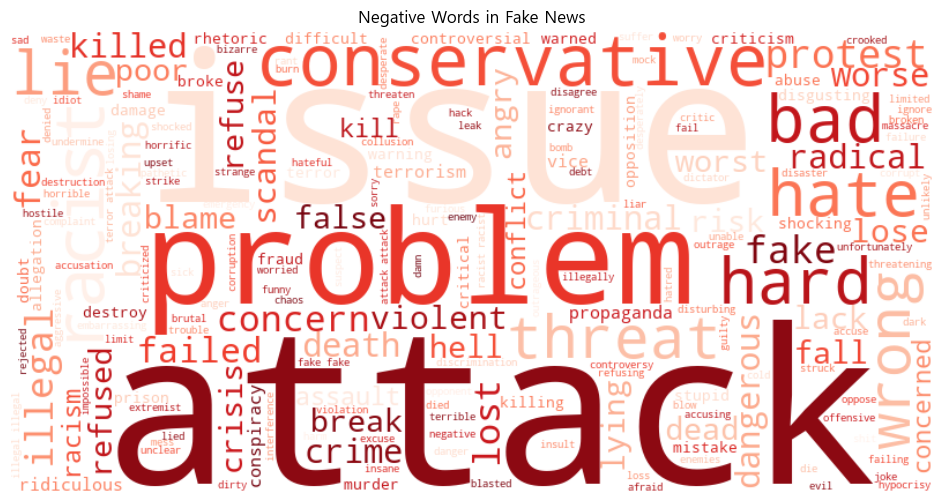

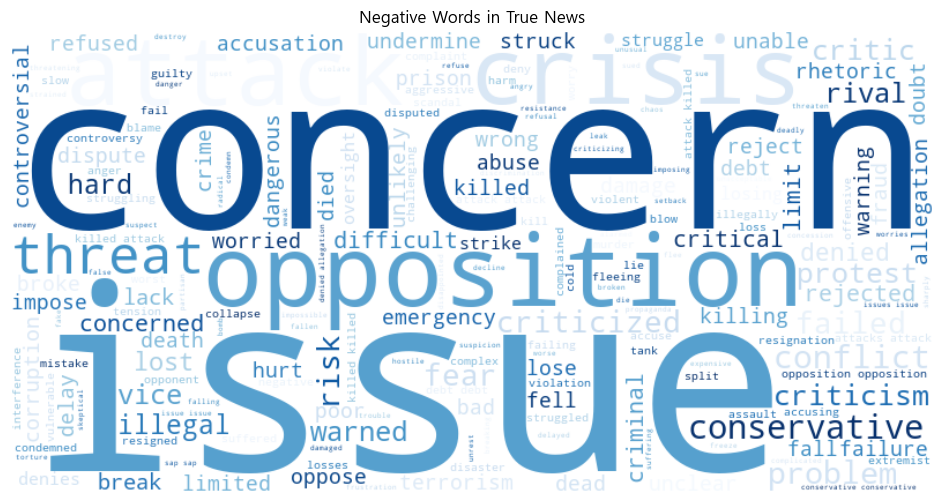

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Malgun Gothic'  #Windows 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     #마이너스 기호 깨짐 방지

#부정적인 단어 텍스트 결합(가짜뉴스)
fake_news_negative_words_combined = ' '.join(fake_news_negative_words)

#워드클라우드 생성
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'
).generate(fake_news_negative_words_combined)

#시각화
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words in Fake News')
plt.show()


#부정적인 단어 텍스트 결합(진짜뉴스)
true_news_negative_words_combined = ' '.join(true_news_negative_words)

#워드클라우드 생성
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Blues'
).generate(true_news_negative_words_combined)

#시각화
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words in True News')
plt.show()


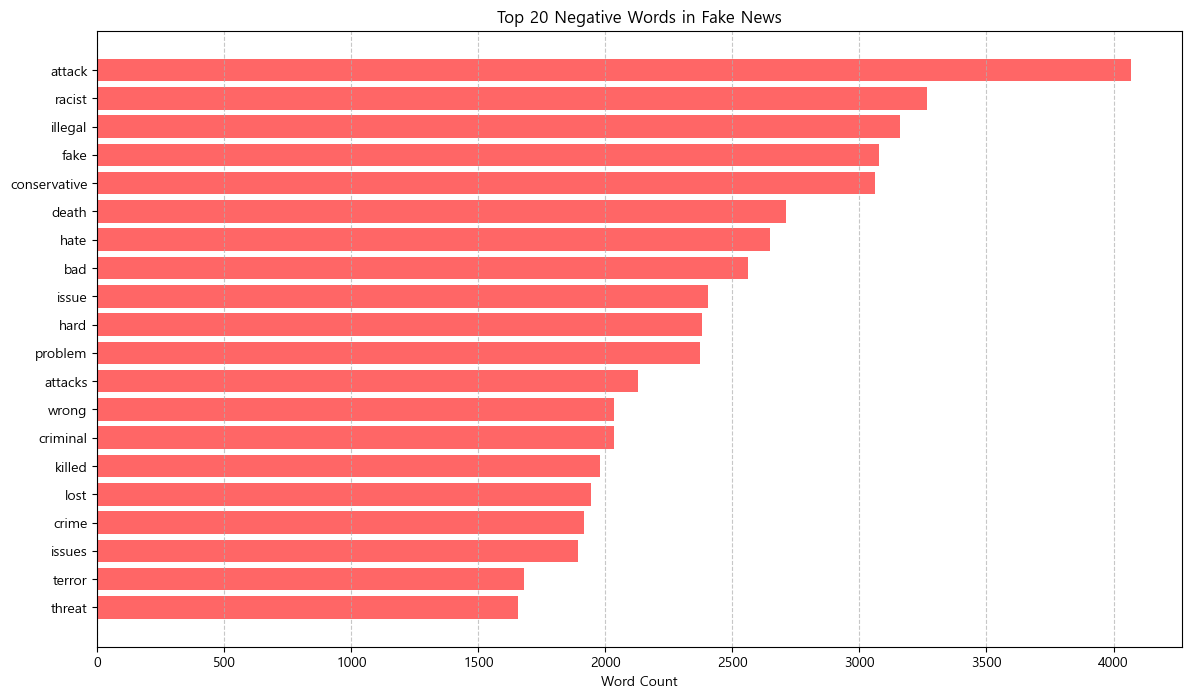

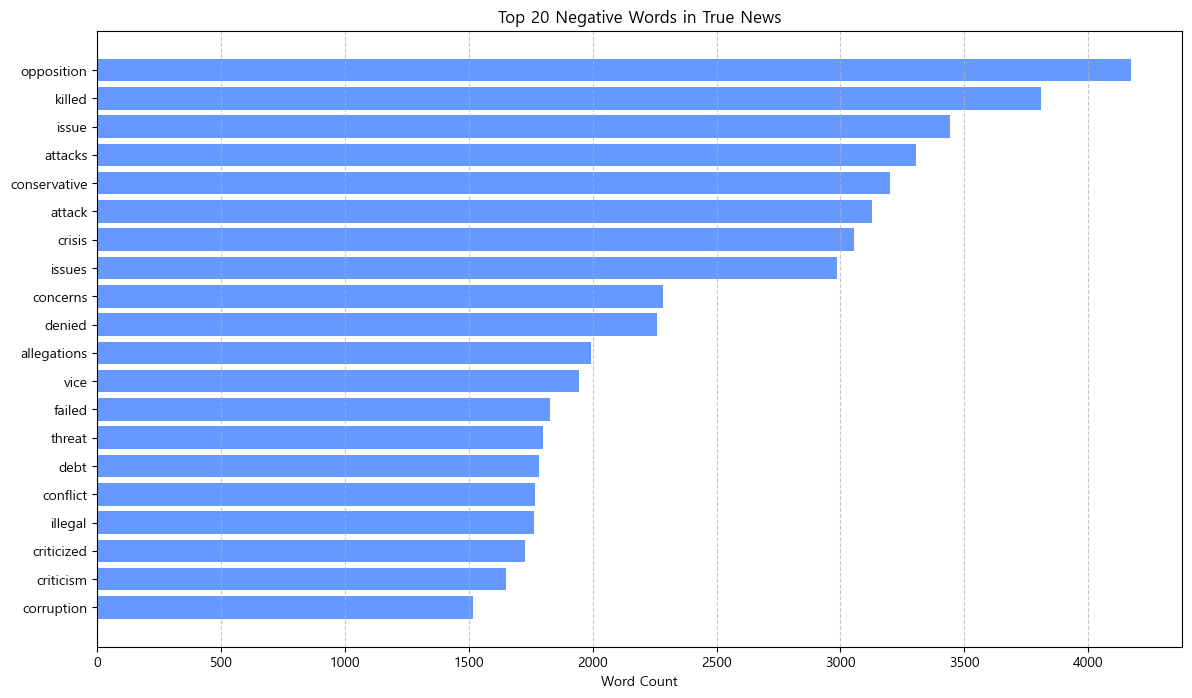

In [ ]:
#가짜 뉴스의 부정 상위 단어 추출
top20_fake_news_negative_words = fake_news_negative_frequency.most_common(20)

#단어와 빈도 리스트로 분리
if top20_fake_news_negative_words:
    words, counts = zip(*top20_fake_news_negative_words)
    words = list(words)
    counts = list(counts)
    
#막대그래프 시각화
plt.figure(figsize=(14, 8))
plt.barh(words, counts, color='#ff6666')
plt.title('Top 20 Negative Words in Fake News')
plt.xlabel('Word Count')
plt.gca().invert_yaxis() # y축 위에서 아래로 작아지는 방향
plt.grid(axis='x', linestyle='--', alpha=0.7) # x축 점선 
plt.show()

#진짜 뉴스의 부정 상위 단어 추출
top20_true_news_negative_words = true_news_negative_frequency.most_common(20)

#단어와 빈도 리스트로 분리
if top20_true_news_negative_words:
    words, counts = zip(*top20_true_news_negative_words)
    words = list(words)
    counts = list(counts)
    
#막대그래프 시각화
plt.figure(figsize=(14, 8))
plt.barh(words, counts, color='#6699ff')
plt.title('Top 20 Negative Words in True News')
plt.xlabel('Word Count')
plt.gca().invert_yaxis() # y축 위에서 아래로 작아지는 방향
plt.grid(axis='x', linestyle='--', alpha=0.7) # x축 점선 
plt.show()



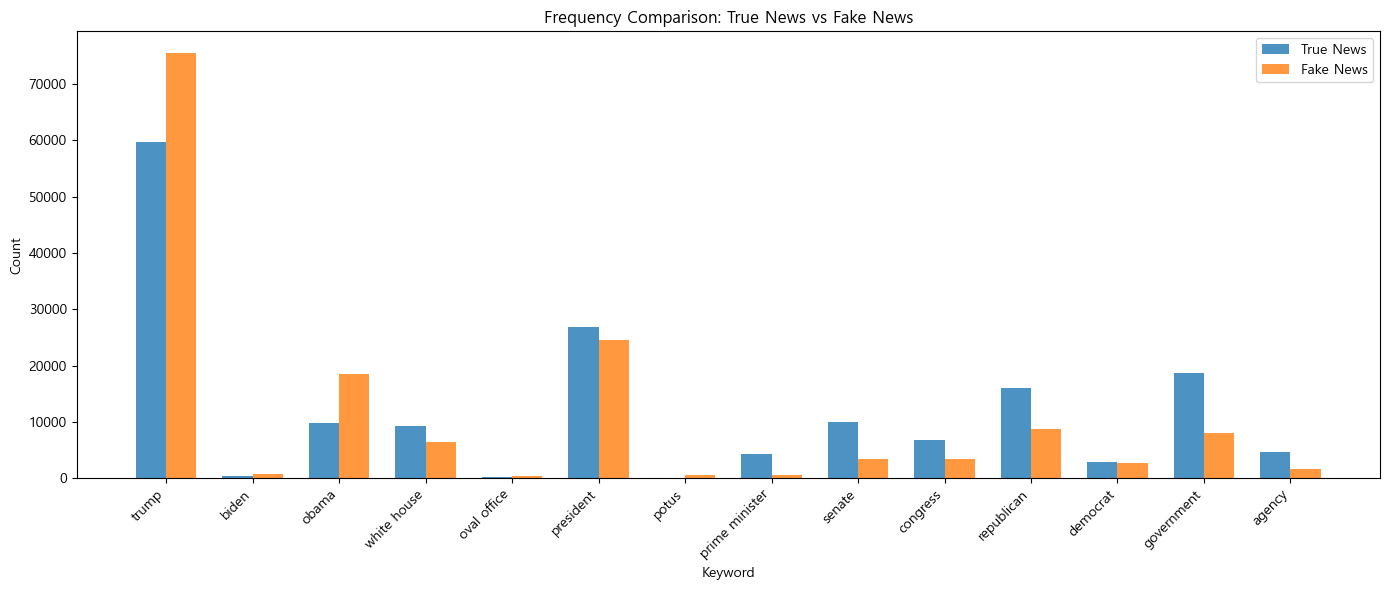

In [ ]:
#키워드 리스트 'presidential_news','political_news'
keywords = [
    'trump', 'biden', 'obama', 'white house', 'oval office', 'president', 'potus',
    'prime minister', 'senate', 'congress', 'republican', 'democrat', 'government', 'agency'
]

true_tokens = word_tokenize(true_news.lower())
fake_tokens = word_tokenize(fake_news.lower())

#단일 단어 키워드는 Counter로, 복합어(white house 등)는 count로 처리
true_counter = Counter(true_tokens)
fake_counter = Counter(fake_tokens)

def keyword_count(tokens, counter, kw):
    if ' ' in kw:
        #복합어는 전체 텍스트에서 count
        return ' '.join(tokens).count(kw)
    else:
        return counter[kw]

true_news_keywords_counts = {kw: keyword_count(true_tokens, true_counter, kw) for kw in keywords}
fake_news_keywords_counts = {kw: keyword_count(fake_tokens, fake_counter, kw) for kw in keywords}

#데이터프레임 정리
df_frequency = pd.DataFrame({
    'Keyword': keywords,
    'True News Count': [true_news_keywords_counts[kw] for kw in keywords],
    'Fake News Count': [fake_news_keywords_counts[kw] for kw in keywords]
})


#키워드 목록과 인덱스 및 그래프 생성
keywords = df_frequency['Keyword']
x = np.arange(len(keywords)) 
width = 0.35
fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width/2, df_frequency['True News Count'], width, label='True News', alpha=0.8)
rects2 = ax.bar(x + width/2, df_frequency['Fake News Count'], width, label='Fake News', alpha=0.8)

ax.set_title('Frequency Comparison: True News vs Fake News')
ax.set_xlabel('Keyword')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(keywords, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


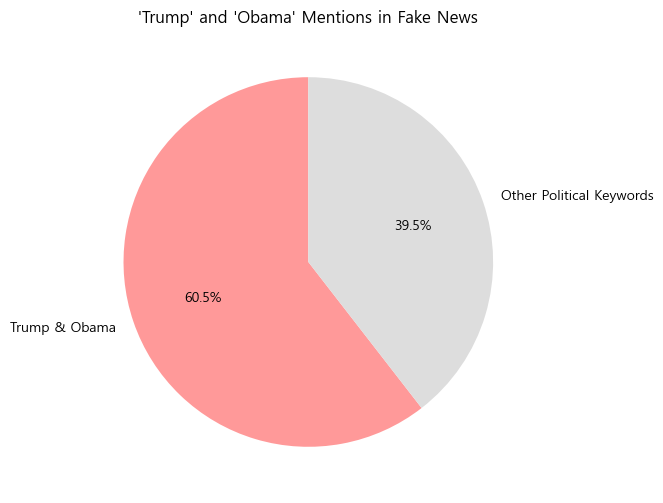

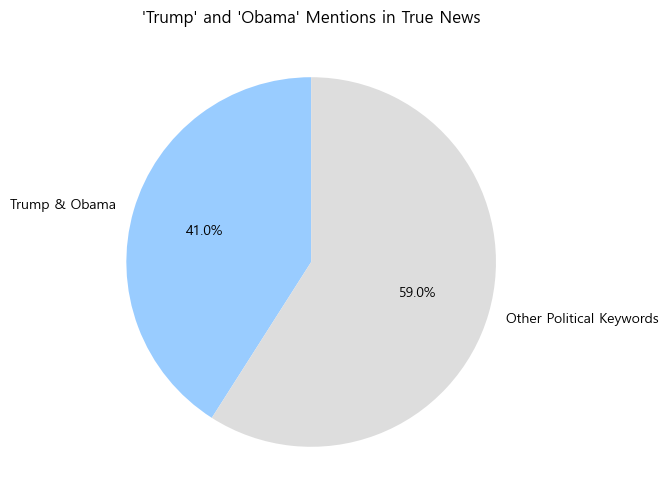

In [ ]:
#관심 있는 키워드
person_keywords = ['trump', 'obama']

fake_news_person_total = sum(fake_news_keywords_counts[kw] for kw in person_keywords) #가짜 뉴스 내 trump, obama
fake_news_total = sum(fake_news_keywords_counts[kw] for kw in keywords) #가짜 뉴스 내 다른 정치 키워드
true_news_person_total = sum(true_news_keywords_counts[kw] for kw in person_keywords) #진짜 뉴스 내 trump, obama
true_news_total = sum(true_news_keywords_counts[kw] for kw in keywords) #진짜 뉴스 내 다른 정치 키워드

#파이차트 시각화
labels = ['Trump & Obama', 'Other Political Keywords']
sizes = [fake_news_person_total, fake_news_total - fake_news_person_total]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#dddddd'])  
plt.title("'Trump' and 'Obama' Mentions in Fake News")
plt.show()

labels = ['Trump & Obama', 'Other Political Keywords']
sizes = [true_news_person_total, true_news_total - true_news_person_total]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#99ccff', '#dddddd'])
plt.title("'Trump' and 'Obama' Mentions in True News")
plt.show()



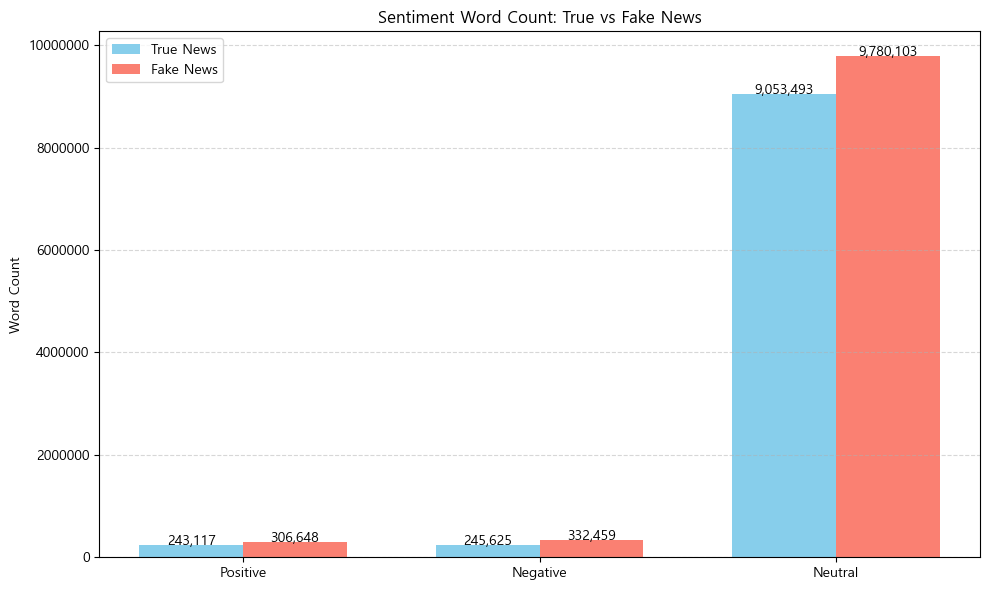

In [ ]:
#감정 단어 수 계산
def sentiment_counts(text):
    tokens = word_tokenize(text.lower())
    total = len(tokens)
    pos = sum(1 for w in tokens if w in positive_words)
    neg = sum(1 for w in tokens if w in negative_words)
    neutral = total - pos - neg
    return pos, neg, neutral

true_pos, true_neg, true_neutral = sentiment_counts(true_news)
fake_pos, fake_neg, fake_neutral = sentiment_counts(fake_news)

#범주별 데이터
categories = ['Positive', 'Negative', 'Neutral']
true_counts = [true_pos, true_neg, true_neutral]
fake_counts = [fake_pos, fake_neg, fake_neutral]

#그룹형 막대그래프 생성
x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, true_counts, width, label='True News', color='skyblue')
plt.bar(x + width/2, fake_counts, width, label='Fake News', color='salmon')

#값 표시
for i in range(len(categories)):
    plt.text(x[i] - width/2, true_counts[i] + 1000, f'{true_counts[i]:,}', ha='center', fontsize=10)
    plt.text(x[i] + width/2, fake_counts[i] + 1000, f'{fake_counts[i]:,}', ha='center', fontsize=10)

plt.xticks(x, categories)
plt.ylabel('Word Count')
plt.title('Sentiment Word Count: True vs Fake News')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()


In [22]:
#감성분석 & 주제 관련 변수 추가

def sentiment_features(text):
    tokens = word_tokenize(text.lower())
    total = len(tokens)
    pos_words = [w for w in tokens if w in positive_words]
    neg_words = [w for w in tokens if w in negative_words]
    pos = len(pos_words)
    neg = len(neg_words)
    polarity = (pos - neg) / total if total else 0
    pos_neg_ratio = pos / (neg + 1)
    unique_pos = len(set(pos_words))
    unique_neg = len(set(neg_words))
    max_pos_freq = Counter(pos_words).most_common(1)[0][1] if pos_words else 0
    max_neg_freq = Counter(neg_words).most_common(1)[0][1] if neg_words else 0
    president_count = sum(1 for w in tokens if w in person_keywords)  
    president_ratio = president_count / total if total else 0  
    return pd.Series([pos, neg, polarity, pos_neg_ratio, unique_pos, unique_neg, max_pos_freq, max_neg_freq, president_ratio])



In [30]:
#통합 데이터 프레임 내에 감성분석 변수 추가
totalnews_df[['pos_count', 'neg_count', 'polarity_score', 'pos_neg_ratio','unique_positive_count', 'unique_negative_count',
    'max_positive_freq', 'max_negative_freq', 'president_ratio']] = totalnews_df['text'].apply(sentiment_features)

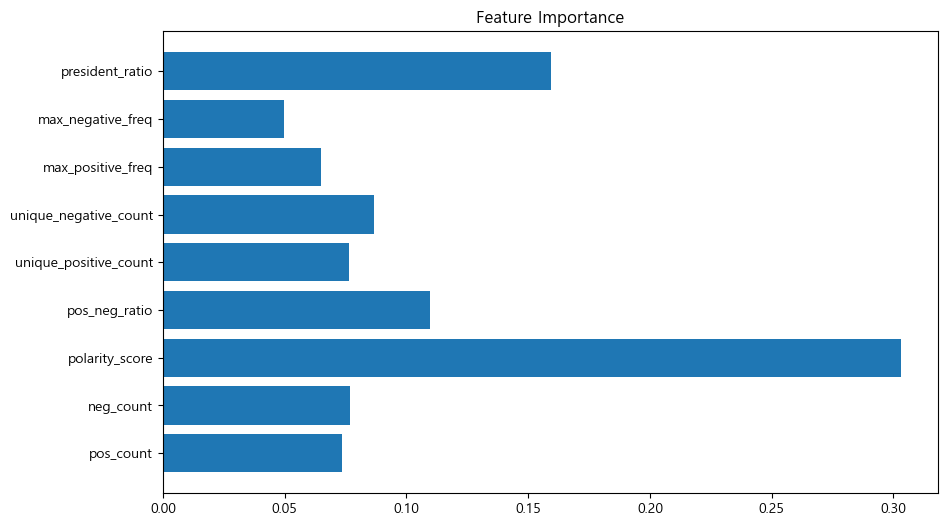

In [ ]:
#감성분석의 변수들의 모델 내 중요도 분석
#RandomForest : 변수 중요도 내장된 feature_importances_ 속성으로 각 변수의 기여도를 정량화합니다, 
#앙상블 기법으로 과적합을 방지하며, 다양한 데이터 유형에 잘 적용됩니다.
#비선형 관계 포착: 트리 기반 모델이기 때문에 변수 간 복잡한 상호작용을 모델링할 수 있습니다
#변수 중요도 계산 방법
#불순도 감소 기준: 각 분할에서 변수가 불순도(지니/엔트로피)를 얼마나 감소시켰는지 누적하여 계산합니다.
#정규화: 모든 트리에서의 평균 불순도 감소량을 정규화해 중요도를 0~1 사이로 표현합니다.
from sklearn.ensemble import RandomForestClassifier

#X는 감성 변수만 있는 데이터프레임
X = totalnews_df[['pos_count', 'neg_count', 'polarity_score', 
                  'pos_neg_ratio', 'unique_positive_count', 
                  'unique_negative_count', 'max_positive_freq', 
                  'max_negative_freq','president_ratio']]
y = totalnews_df['label']

model = RandomForestClassifier()
model.fit(X, y)

#변수 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.title('Feature Importance')
plt.show()

#중요도 0.05제거 : 의미없는 변수의 하향선 ==> 감성분석 변수 모두 유효 --> 그대로 진행

In [ ]:
from sklearn.model_selection import train_test_split

#전체 데이터를 Train/Test를 8:2로 분할하는 함수
def split_data(totalnews_df, test_size=0.2, random_state=42):
    train_df, test_df = train_test_split(
        totalnews_df,
        test_size=test_size,
        random_state=random_state,
        stratify=totalnews_df['label']
    )
    print(f"Train 크기: {len(train_df)}")
    print(f"Test 크기: {len(test_df)}")
    return train_df, test_df

train_df, test_df = split_data(totalnews_df)

▶ Train set 크기: 34267
▶ Test set 크기: 8567


In [ ]:
#숫자형 변수(감성 분석) 표준화 진행
#정규화 vs 표준화 = 0~1사이의 값으로 vs 평균 0, 표준편차 1로 맞추기
#우리 데이터에는 음수부터 30대의 다양한 값 + 소수점까지 너무 다양한 값 ==> 정규화보단 표준화가 다양한 유형의 값 처리 가능
from sklearn.preprocessing import StandardScaler

# 표준화할 감성 변수 리스트
sentiment_features_word = [
    'pos_count', 'neg_count', 'polarity_score', 'pos_neg_ratio',
    'unique_positive_count', 'unique_negative_count',
    'max_positive_freq', 'max_negative_freq','president_ratio'
]

#StandardScaler 객체 생성
scaler = StandardScaler()

#표준화 적용
train_df[sentiment_features_word] = scaler.fit_transform(train_df[sentiment_features_word])
test_df[sentiment_features_word] = scaler.transform(test_df[sentiment_features_word])


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import numpy as np

#사전학습된 BERT 모델 불러오기 (GPU 사용 가능 시 자동 전환)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
model.eval()
#빠른 생성위한 GPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) #모델을 GPU로 이동

def extract_cls_embedding(text_list, batch_size=32): #배치 크기 기본값 32
    text_list = [str(text) for text in text_list]
    cls_embeddings = []

    #배치 단위 처리
    for i in tqdm(range(0, len(text_list), batch_size), desc="BERT 임베딩 생성"):
        batch = text_list[i:i+batch_size]

        #텍스트 토큰화
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            padding=True,  #배치 처리 시 필수
            max_length=512
        ).to(device)  #입력 데이터도 GPU로 이동

        #BERT에 입력
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden = outputs.last_hidden_state #최종 768차원

            #[CLS] 벡터 추출
            cls_vectors = last_hidden[:, 0, :]

        #numpy 변환 및 리스트 저장
        cls_embeddings.extend(cls_vectors.cpu().numpy())

    return np.array(cls_embeddings)


In [ ]:
import pandas as pd
import os

#임베딩 파일 생성 및 로드
#BERT임베딩에 많은 시간&자원 소모 문제 -> 로컬 임베딩 파일 생성, 향후 사용시 로드(단편적으로는 문제해결, 근본적 문제해결 X)
def save_load_embeddings(train_df, test_df):
    #파일 경로 설정
    paths = {
        'train_title': 'X_train_title_bert.npy',
        'train_text': 'X_train_text_bert.npy',
        'test_title': 'X_test_title_bert.npy',
        'test_text': 'X_test_text_bert.npy'
    }
    results = {}
    #임베딩 파일 저장 및 로드
    if os.path.exists(paths['train_title']):
        print("Train 제목 임베딩 파일 로드")
        X_train_title = np.load(paths['train_title'])
    else:
        print("Train 제목 임베딩 생성 시작")
        X_train_title = extract_cls_embedding(train_df['cleaned_title'].tolist())
        np.save(paths['train_title'], X_train_title)
        print(f"저장 완료: {paths['train_title']}")
    results['train_title'] = X_train_title

    if os.path.exists(paths['train_text']):
        print("Train 본문 임베딩 파일 로드")
        X_train_text = np.load(paths['train_text'])
    else:
        print("Train 본문 임베딩 생성 시작")
        X_train_text = extract_cls_embedding(train_df['cleaned_text'].tolist())
        np.save(paths['train_text'], X_train_text)
        print(f"저장 완료: {paths['train_text']}")
    results['train_text'] = X_train_text

    if os.path.exists(paths['test_title']):
        print("Test 제목 임베딩 파일 로드")
        X_test_title = np.load(paths['test_title'])
    else:
        print("Test 제목 임베딩 생성 시작")
        X_test_title = extract_cls_embedding(test_df['cleaned_title'].tolist())
        np.save(paths['test_title'], X_test_title)
        print(f"저장 완료: {paths['test_title']}")
    results['test_title'] = X_test_title
    
    if os.path.exists(paths['test_text']):
        print("Test 본문 임베딩 파일 로드")
        X_test_text = np.load(paths['test_text'])
    else:
        print("Test 본문 임베딩 생성 시작")
        X_test_text = extract_cls_embedding(test_df['cleaned_text'].tolist())
        np.save(paths['test_text'], X_test_text)
        print(f"저장 완료: {paths['test_text']}")
    results['test_text'] = X_test_text
    
    
    #결합해서 반환
    X_train_combined = np.concatenate([results['train_title'], results['train_text']], axis=1)
    X_test_combined = np.concatenate([results['test_title'], results['test_text']], axis=1)
    return X_train_combined, X_test_combined

#임베딩 생성/로드
X_train_combined, X_test_combined = save_load_embeddings(train_df, test_df)

▶ Train 제목 임베딩 파일 로드
▶ Train 본문 임베딩 파일 로드
▶ Test 제목 임베딩 생성 시작


BERT 임베딩 생성: 100%|██████████| 268/268 [02:29<00:00,  1.80it/s]


  저장 완료: X_test_title_bert.npy
▶ Test 본문 임베딩 생성 시작


BERT 임베딩 생성: 100%|██████████| 268/268 [44:08<00:00,  9.88s/it]


  저장 완료: X_test_text_bert.npy

✔ 최종 임베딩 차원
Train: (34267, 1536)
Test: (8567, 1536)


In [ ]:
#BERT 임베딩 파일(배열 형태)과 표준화된 감성 변수(데이터 프레임 내에 Numpy 배열로 존재) 결합하는 최종 결합 코드
#BERT 임베딩 + 감성 변수 결합(768차원+768차원인 BERT임베딩 + 변수 차원 결합)
X_train_final = np.concatenate(
    [X_train_combined, train_df[sentiment_features_word].values], 
    axis=1
)
X_test_final = np.concatenate(
    [X_test_combined, test_df[sentiment_features_word].values], 
    axis=1
)

#레이블 추출
y_train = train_df['label'].values
y_test = test_df['label'].values 

In [ ]:
#교차검증 성능 비교 코드
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import time

#5-Fold 교차검증
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

print("5-Fold 교차검증 결과\n")

cv_results = {}
for name, model in models.items(): #cv = 5(5차 교차검증)
    scores = cross_validate(
        model,
        X_train_final,
        y_train,  
        cv=5,
        scoring=['accuracy', 'precision', 'recall', 'f1'],
        n_jobs=1  
    )
    cv_results[name] = {
        'Accuracy': f"{np.mean(scores['test_accuracy']):.4f}",
        'Precision': f"{np.mean(scores['test_precision']):.4f}",
        'Recall': f"{np.mean(scores['test_recall']):.4f}",
        'F1-score': f"{np.mean(scores['test_f1']):.4f}",
        'Fit Time (sec)': f"{np.mean(scores['fit_time']):.1f}"
    }

cv_df = pd.DataFrame(cv_results).T
print(cv_df)



5-Fold 교차검증 결과
                    Accuracy Precision  Recall F1-score Fit Time (sec)
Logistic Regression   0.9971    0.9969  0.9974   0.9971            0.9
Linear SVM            0.9969    0.9968  0.9970   0.9969            3.8
Random Forest         0.9799    0.9791  0.9807   0.9799          146.7
Naive Bayes           0.9353    0.9247  0.9479   0.9361            0.6
Gradient Boosting     0.9817    0.9791  0.9845   0.9818         1731.4
XGBoost               0.9913    0.9897  0.9930   0.9913           16.3


In [ ]:
#테스트셋 평가
#한번도 사용되지 않은 테스트 셋으로 성능 평가 -> 최종 성능 공식화
print("테스트셋 최종 평가 결과\n")

results = []
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_final, y_train)
    train_time = time.time() - start_time
    
    y_pred = model.predict(X_test_final)
    
    results.append({
        'Model': name,
        'Accuracy': f"{accuracy_score(y_test, y_pred):.4f}",
        'Precision': f"{precision_score(y_test, y_pred):.4f}",
        'Recall': f"{recall_score(y_test, y_pred):.4f}",
        'F1-score': f"{f1_score(y_test, y_pred):.4f}",
        'Test Time (sec)': f"{train_time:.1f}"
    })

results_df = pd.DataFrame(results)
print(results_df)


테스트셋 최종 평가 결과


NameError: name 'models' is not defined

In [ ]:
#혼돈 행렬 출력 (Logistic Regression 기준) 
LogisticRegression_model = models["Logistic Regression"].fit(X_train_final, y_train)
y_pred = LogisticRegression_model.predict(X_test_final)
print("LogisticRegression 혼동 행렬\n")
print(confusion_matrix(y_test, y_pred))
#TN/FP : 긍정 예측한 것중 긍정 / 부정 예측한 것중 긍정
#FN/TP : 긍정 예측한 것중 부정 / 부정 예측한 것중 부정
#TP&TN이 높게 나오고 FN&FP가 낮게 나오는 것이 이상적

NameError: name 'models' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression
import joblib

#성능 분석하여 최적 모델 선정(Logistic Regression)
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train_final, y_train)

#모델 저장
joblib.dump(final_model, "logreg_model.pkl")

#Scaler 저장 (감성 변수 표준화에 사용)
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [ ]:
#FastAPI 기반 데모: 기존 Jupyter 함수와 변수 재사용 버전
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel

app = FastAPI()

bert_model = AutoModel.from_pretrained("bert-base-uncased")
bert_model.eval()
bert_model = bert_model.to(device)

#단건 임베딩 함수만 정의
def extract_single_bert_embedding(text: str):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        cls_vector = outputs.last_hidden_state[:, 0, :]  # [1, 768]
    return cls_vector.cpu().numpy()

#모델 및 API
import joblib

model = joblib.load("logreg_model.pkl")
scaler = joblib.load("scaler.pkl")

class NewsRequest(BaseModel):
    title: str
    text: str

class PredictResponse(BaseModel):
    is_fake: bool
    probability: float
    model: str

@app.post("/predict", response_model=PredictResponse)
async def predict(news: NewsRequest):
    try:
        cleaned_title = process_text(news.title)
        cleaned_text = process_text(news.text)

        title_vec = extract_single_bert_embedding(cleaned_title)
        text_vec = extract_single_bert_embedding(cleaned_text)
        combined_vec = np.concatenate([title_vec, text_vec], axis=1)  # (1, 1536)

        senti_vec = sentiment_features(cleaned_title + " " + cleaned_text).values.reshape(1, -1)
        scaled_senti = scaler.transform(senti_vec)

        full_input = np.concatenate([combined_vec, scaled_senti], axis=1)  # (1, 1545)

        prediction = model.predict(full_input)
        proba = model.predict_proba(full_input)[0]

        return PredictResponse(
            is_fake=bool(prediction[0] == 0),
            probability=float(proba[prediction[0]]),
            model="Logistic Regression (Accuracy: 99.67%, Mean : 99.67%)"
        )
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

@app.get("/")
async def health_check():
    return {"status": "OK", "model": "Logistic Regression + BERT"}

#Jupyter 전용 실행 트리거 : Jupyter에서 직접 서버를 실행할 때만 필요함
try:
    import nest_asyncio
    import uvicorn
    nest_asyncio.apply()
    print("FastAPI 서버 실행 중: http://localhost:8000")
    uvicorn.run(app, host="0.0.0.0", port=8000)
except Exception as e:
    print("FastAPI 서버 실행 실패:", e)


✅ FastAPI 서버 실행 중: http://localhost:8000


INFO:     Started server process [102984]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:50988 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:50988 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:50991 - "POST /predict HTTP/1.1" 200 OK


c:\Users\JinsuRoh\anaconda3\envs\tfenvJS\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


INFO:     127.0.0.1:51056 - "POST /predict HTTP/1.1" 422 Unprocessable Entity
INFO:     127.0.0.1:51057 - "POST /predict HTTP/1.1" 200 OK


c:\Users\JinsuRoh\anaconda3\envs\tfenvJS\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


INFO:     127.0.0.1:51068 - "POST /predict HTTP/1.1" 422 Unprocessable Entity
INFO:     127.0.0.1:51069 - "POST /predict HTTP/1.1" 200 OK


c:\Users\JinsuRoh\anaconda3\envs\tfenvJS\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


INFO:     127.0.0.1:51076 - "POST /predict HTTP/1.1" 200 OK


c:\Users\JinsuRoh\anaconda3\envs\tfenvJS\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


INFO:     127.0.0.1:51095 - "POST /predict HTTP/1.1" 200 OK


c:\Users\JinsuRoh\anaconda3\envs\tfenvJS\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [102984]


향후 해결해야할 문제 1. 하이퍼파리미터 튜닝